In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pathlib import Path
import os, sys, datetime, time, random, fnmatch, math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import skimage.metrics

import torch
from torchvision import transforms as tvtransforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.utils as vutils
import torch.utils.tensorboard as tensorboard
import torch.nn as nn

# Own functions
import dataloaders
import transforms
import blocks
import pytorch_msssim
import losses
import pix2pix
import OhModel

# Flags:
flag_debug = False
flag_load_previous_save = False # load from checkpoint?  Checkpoint stored at PATH_X_INTERMEDIATE variables below

# Input directories
training_directory_source = "G:/DanielLam/JSRT/augmented/train/source"
training_directory_boneless = "G:/DanielLam/JSRT/augmented/train/target/"
val_length = 10 # Number of validation images
#CXR_directory = "D:/data/POLYU_COVID19_CXR_CT_Cohort1"
#CXR_directory = "G:\DanielLam\POLYU_COVID19_CXR_CT_Cohort1"

# Save directories
output_save_directory = Path("./runs/OhModel_v11/")
output_save_directory.mkdir(parents=True, exist_ok=True)
PATH_G = os.path.join(output_save_directory, "netG.pt") # path to save weights for generator
PATH_D = os.path.join(output_save_directory, "netD.pt") # path to save weights for discriminator
PATH_SAVE_NETWORK_INTERMEDIATE = os.path.join(output_save_directory, "nets_int.tar") # path to save weights for BOTH G and D


randomisation_seed = 42

# Settings for training:
num_epochs_generator = 300 # Isola et al. Image-to-Image Translation with CGANs
_batch_size = 8 # 1 per GPU at least
discriminator_keys_images = ["source", "boneless"]
generator_keys_images = "source"
generator_target = "boneless"
image_spatial_size = (512,512) # For the Oh Model, this is 2x the model fed through the network.

# Adam Optimiser

# Discriminator
lr_D = 0.0008

# Generator
# Parameters from: Oh and Yun 2018. Learning Bone Suppression from Dual-energy Chest X-rays using Adversarial Networks.
lr_G = 0.0008
beta1=0.5
beta2=0.999

reg_L1 = 100




# Weight Initialisation
def weights_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        #nn.init.normal_(m.weight.data, 0., 0.02)
        nn.init.kaiming_normal_(m.weight.data, a=0)
        try:
            nn.init.constant_(m.bias.data, 0.)
        except:
            pass
    if isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.)

# Techniques for improved training
# Label Smoothing
random.seed(0)
flip_rate_threshold = 0.10 #0.05 # for this, 0.25 means 25% of the time, real and fake labels are flipped.

# Loss Functions
adversarial_loss = nn.BCEWithLogitsLoss()
# IF USING BCEWithLogitsLoss, do NOT use Sigmoid as output activation for Discriminator

# Decide which device we want to run on
ngpu = 1
gpu_device_list = [1] #list(range(ngpu))
device = torch.device("cuda" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(device)
# Current date:
current_date=datetime.datetime.today().strftime('%Y-%m-%d')

cuda


In [2]:
# Set up datasets and dataloaders
ds_training = dataloaders.JSRT_CXR(training_directory_source, training_directory_boneless,
                                 transform=tvtransforms.Compose([
                                     transforms.Rescale(image_spatial_size, discriminator_keys_images, "PixelSize"),
                                     transforms.ImageComplement(discriminator_keys_images),
                                     transforms.RescalingNormalisation(discriminator_keys_images,(0,1)),
                                     transforms.HaarTransform(discriminator_keys_images),
                                     transforms.ToTensor(discriminator_keys_images),
                                     ]))
print(len(ds_training))

# Training and Validation Set
lengths=(len(ds_training)-val_length, val_length)
ds_training, ds_val = random_split(ds_training, lengths, generator=torch.Generator().manual_seed(randomisation_seed))

dl_training = DataLoader(ds_training, batch_size=_batch_size,
                         shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size= 3,
                    shuffle=True, num_workers=0)

# Fixed Test Sample
fixed_test_image = next(iter(dl_val))



4000


torch.Size([3, 4, 256, 256])
tensor(0.0055)


<Figure size 432x288 with 0 Axes>

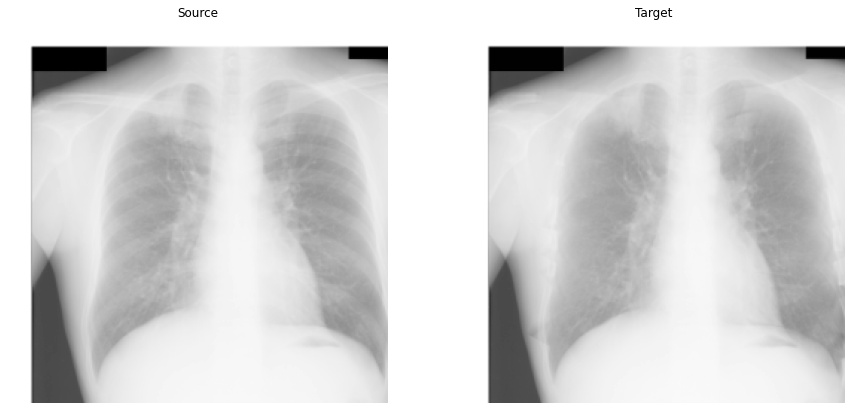

In [3]:
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(15,15))
print(fixed_test_image["source"].shape)
ax[0].imshow(fixed_test_image[generator_keys_images][0,0,:], cmap='gray')
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(fixed_test_image[generator_target][0,0,:], cmap='gray')
ax[1].set_title("Target")
ax[1].axis("off")
plt.show

msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1)
msssim_loss = 1 - msssim(fixed_test_image[generator_target], fixed_test_image[generator_keys_images])
print(msssim_loss)

In [4]:
## Implementation of Network 
# Network Structure
sample = fixed_test_image
_input_array_shape_classifier = [_batch_size , sample["source"].shape[1]*2, sample["source"].shape[2], sample["source"].shape[3]]  # 2 channels -- channel 0 for source, channel 1 for real/fake boneless
_input_array_shape_generator = [_batch_size , sample["source"].shape[1], sample["source"].shape[2], sample["source"].shape[3]]

# Networks
netG = OhModel.Generator(_input_array_shape_generator, reluType="normal", use_bias=True)
netD = OhModel.Discriminator(_input_array_shape_classifier, num_kernels=32, kernel_dims=32, use_bias = True, reluType="normal")

# Initialise weights
netG.apply(weights_init)
netD.apply(weights_init)

# Multi-GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, gpu_device_list)
    netD = nn.DataParallel(netD, gpu_device_list)

netG = netG.to(device)
netD = netD.to(device)


Oh Model Generator thought to use summation skip connection.


In [ ]:
## Training Loop for GAN
import losses
from torch.optim import lr_scheduler

# Helper Functions
def set_requires_grad(nets, requires_grad=False):
    """https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/f13aab8148bd5f15b9eb47b690496df8dadbab0c/models/base_model.py#L219
    Set requires_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad


msssim = pytorch_msssim.MSSSIM(window_size=11, size_average=True, channel=1, normalize="relu")

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
optimizerG.zero_grad()
optimizerD.zero_grad()


"""# Optimizer scheduling
num_epochs_ini_lr = 200
num_epochs_decay = num_epochs_generator - num_epochs_ini_lr
# The lambda-rule defines the decay in the learning rate as a FACTOR of the learning rate -- it does NOT define the absolute learning rate
def lambda_rule(epoch, num_epochs_ini_lr=num_epochs_ini_lr, current_epoch=0, num_epochs_decay=num_epochs_decay):
    lr_l = 1.0 - max(0, epoch + current_epoch - num_epochs_ini_lr) / float(num_epochs_decay + 1)
    return lr_l
schedulerD = lr_scheduler.LambdaLR(optimizerD, lr_lambda=lambda_rule, verbose=True)
schedulerG = lr_scheduler.LambdaLR(optimizerG, lr_lambda=lambda_rule, verbose=True)
"""
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_G_z1_list = []
D_G_z2_list = []
D_x_list = []
accuracy_list = []
iters = 0
reals_shown = []

# optionally resume from a checkpoint
if flag_load_previous_save:
    if os.path.isfile(PATH_SAVE_NETWORK_INTERMEDIATE):
        print("=> loading checkpoint '{}'".format(PATH_SAVE_NETWORK_INTERMEDIATE))
        checkpoint = torch.load(PATH_SAVE_NETWORK_INTERMEDIATE)
        start_epoch = checkpoint['epoch_next']
        reals_shown_now = checkpoint['reals_shown']
        schedulerG.load_state_dict(checkpoint['schedulerG_state_dict'])
        schedulerD.load_state_dict(checkpoint['schedulerD_state_dict'])
        netG.load_state_dict(checkpoint['modelG_state_dict'])
        netD.load_state_dict(checkpoint['modelD_state_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])
        print("=> loaded checkpoint '{}' (epoch {}, reals shown {})".format(PATH_SAVE_NETWORK_INTERMEDIATE, 
                                                                            start_epoch, reals_shown_now))
        if start_epoch > num_epochs_generator:
            raise RuntimeError("Checkpoint epoch {} exceeds the total number of epochs {}".format(start_epoch, num_epochs_generator))
    else:
        print("=> NO CHECKPOINT FOUND AT '{}'" .format(PATH_SAVE_NETWORK_INTERMEDIATE))
        raise RuntimeError("No checkpoint found at specified path.")
else:
    print("FLAG: NO CHECKPOINT LOADED.")
    reals_shown_now = 0
    start_epoch=0

print("Beginning Training...")
# Initialise history buffer / image pool
imagePool = blocks.ImageBuffer(pool_size=_batch_size, buffer_out_rate=0.5)
set_requires_grad([netD, netG], True)
# For each epoch
for epoch in range(start_epoch, num_epochs_generator):
    for i, data in enumerate(dl_training):
        
        ############################
        # Labels
        ############################
        # Label Smoothing as mentioned by Salimans et al. 2016 Improved Techniques for Training GANs
        real_label = 1. #random.uniform(0.7,1.0) 
        fake_label = 0. #random.uniform(0.0,0.3)
        
        # Label flipping to cripple discriminator
        flip_probability = random.uniform(0.,1.)
        fake_label_original = fake_label
        real_label_original = real_label
        if flip_probability < flip_rate_threshold:
            fake_label = real_label_original
            real_label = fake_label_original
        
        fake_label = torch.tensor(fake_label)
        real_label = torch.tensor(real_label)
        ###########################
        # (0) Generate fake image batch with G
        ###########################
        conditioning_data = data['source'].to(device)
        fake = netG(conditioning_data)    
        
        # Image Pool
        fake = imagePool.query(fake)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Train with all-real batch
        optimizerD.zero_grad()
        
        ## REAL DATA
        real_data = torch.cat((data['source'].to(device), data[generator_target].to(device)), dim=1)
        # Forward pass real batch through D and flatten
        pred_real = netD(real_data)
        label_real = real_label.expand_as(pred_real).to(device)
        # Calculate loss on all-real batch
        #print(pred_real)
        #print(label_real)
        errD_real = adversarial_loss(pred_real, label_real)
        
        
        ## FAKE DATA
        fake_data = torch.cat((data['source'].to(device) , fake), dim=1)
        # Fake is detached because the .backwards() command destroys parts of the computational graph
        pred_fake = netD(fake_data.detach())
        label_fake = fake_label.expand_as(pred_fake).to(device)
        # Calculate loss on the all-fake batch
        errD_fake = adversarial_loss(pred_fake, label_fake)
        
        # Calculate the gradients for this batch together
        errD = (errD_fake + errD_real)*0.5
        errD.backward()
        
        # Update D
        optimizerD.step()
        
        D_x = pred_real.mean().item()
        D_G_z1 = pred_fake.mean().item() 
        
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.zero_grad()
        real_label = torch.tensor(real_label_original) # only flip for discriminator
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # fake CANNOT be detached here.
        fake_data = torch.cat((data['source'].to(device), fake), dim=1)
        pred_fake = netD(fake_data)
        label_real = real_label.expand_as(pred_fake).to(device)  # fake labels are real for generator cost
        # Calculate G's loss based on this output
        errG = adversarial_loss(pred_fake, label_real) + reg_L1*losses.criterion_L1Loss(fake.detach(), data[generator_target].detach().to(device))
        # Calculate gradients for G and update optimizer
        errG.backward()
        optimizerG.step()
        
        D_G_z2 = pred_fake.mean().item()
        
        # Output training stats
        if i % 200 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x,z): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs_generator, i, len(dl_training),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        D_G_z1_list.append(D_G_z1)
        D_G_z2_list.append(D_G_z2)
        D_x_list.append(D_x)
        
        # Check how the generator is doing by saving G's output on a fixed test image
        if reals_shown_now%(100*_batch_size)==0: #(iters % 100 == 0) or ((epoch == num_epochs_generator-1) and (i == len(dl_training)-1)):
            with torch.no_grad():
                val_cleaned = netG(fixed_test_image["source"].to(device)).detach().cpu()
            print("Printing to img_list")
            img_list.append(vutils.make_grid(val_cleaned[:,0,:,:], padding=2, normalize=True))
        
        iters += 1
        reals_shown_now += _batch_size
        reals_shown.append(reals_shown_now)
        
        if flag_debug and i == 2:
            raise RuntimeError("DEBUGGING -- REMOVE THIS IF CONDITION IN FULL TEST")
            
    # For each epoch, step scheduler
    #schedulerD.step()
    #schedulerG.step()
    
    # Save the network in indications
    if epoch % 5 == 0 and not flag_debug:
        save_name_preExt, ext = os.path.splitext(PATH_SAVE_NETWORK_INTERMEDIATE)
        save_name = save_name_preExt + "_" + str(epoch) + ext
        torch.save({
        'epochs_completed': epoch+1,
        'epoch_next': epoch+1,
        'modelG_state_dict': netG.state_dict(),
        'modelD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'lossG': errG,
        'lossD': errD,
        #'schedulerG_state_dict': schedulerG.state_dict(),
        #'schedulerD_state_dict': schedulerG.state_dict(),
        'reals_shown': reals_shown_now
        }, save_name)
        print("Saved Intermediate: "+ str(save_name))
        
    # Per epoch, evaluate model on validation data
    netG.eval()
    with torch.no_grad():
        dataiter_val = iter(dl_val)
        val_sample = dataiter_val.next()
        val_source = val_sample["source"].to(device)
        val_output = netG(val_source).cpu()
        # Calculate loss of val_output v.s. the actual desired output
        
        pixel_distance = msssim(val_output, val_sample[generator_target])
        print('[%d/%d]\tMS-SSIM: %.4f'
                  % (epoch, num_epochs_generator, pixel_distance))
        accuracy_list.append(pixel_distance)
    netG.train()

# SAVE WEIGHTS
if not flag_debug:
    torch.save(netG.state_dict(), PATH_G)
    torch.save(netD.state_dict(), PATH_D)


FLAG: NO CHECKPOINT LOADED.
Beginning Training...
[0/300][0/499]	Loss_D: 0.7518	Loss_G: 61.2719	D(x,z): -0.5637	D(G(z)): -0.5164 / -1.1797
Printing to img_list
Printing to img_list
[0/300][200/499]	Loss_D: 0.0749	Loss_G: 62.1643	D(x,z): 2.5515	D(G(z)): -2.6128 / -2.7262
Printing to img_list
Printing to img_list
[0/300][400/499]	Loss_D: 0.0813	Loss_G: 62.0263	D(x,z): 2.5164	D(G(z)): -2.4523 / -2.5644
Printing to img_list
Saved Intermediate: runs\OhModel_v11\nets_int_0.tar
[0/300]	MS-SSIM: 0.0609
[1/300][0/499]	Loss_D: 0.0749	Loss_G: 62.6670	D(x,z): 2.6194	D(G(z)): -2.5152 / -2.4095
Printing to img_list
Printing to img_list
[1/300][200/499]	Loss_D: 0.2285	Loss_G: 60.8263	D(x,z): 1.3281	D(G(z)): -1.4025 / -1.4675
Printing to img_list
Printing to img_list
[1/300][400/499]	Loss_D: 0.1974	Loss_G: 61.4638	D(x,z): 1.8525	D(G(z)): -1.4778 / -1.6858
Printing to img_list
[1/300]	MS-SSIM: 0.0000
[2/300][0/499]	Loss_D: 0.1434	Loss_G: 60.2021	D(x,z): 1.8798	D(G(z)): -1.8700 / -1.9112
Printing to img

In [ ]:
# Inference

# Plot G and D loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(reals_shown, G_losses,label="G")
plt.plot(reals_shown, D_losses,label="D")
plt.xlabel("reals_shown")
plt.ylabel("Loss")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "training_loss"+".png"))
plt.show()
# Plot D errors
plt.figure(figsize=(10,5))
plt.title("Discriminator Error during Training")
plt.plot(reals_shown, D_G_z2_list,label="D Error for Generator Data")
plt.plot(reals_shown, D_x_list,label="D Error for Real Data")
plt.xlabel("reals_shown")
plt.ylabel("D Error")
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "D_errors"+".png"))
plt.show()

# Plot Pixel Distance at each Epoch
plt.figure(figsize=(10,5))
plt.title("Accuracy for generated v.s. true "+generator_target)
plt.plot(accuracy_list)
plt.xlabel("Epochs")
plt.ylabel("MS-SSIM")
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "accuracy"+".png"))
plt.show()

# ANIMATED VALIDATION IMAGE
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
print(img_list[0].shape)
ani = animation.ArtistAnimation(fig, ims, interval=200, repeat_delay=1000, blit=True)
if not flag_debug:
    ani.save(os.path.join(output_save_directory, current_date+"generator_output.mp4"), dpi=300)

# Final Model:
with torch.no_grad():
    input_image = fixed_test_image['source']
    input_images = vutils.make_grid(input_image[0:1,:,:,:], padding=2, normalize=True)
    target_images = vutils.make_grid(fixed_test_image['boneless'][0:1,:,:,:], padding=2, normalize=True)
    net = net.cpu()
    output_image = net(input_image[0:1,:,:,:]).detach().cpu()
    output_images = vutils.make_grid(output_image, padding=2, normalize=True)
print(str(torch.max(output_images)) + "," + str(torch.min(output_images)))
plt.figure(1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(np.transpose(input_images, (1,2,0)), vmin=0, vmax=1)
ax[0].set_title("Source")
ax[0].axis("off")
ax[1].imshow(np.transpose(output_images, (1,2,0)), vmin=0, vmax=1)
ax[1].set_title("Suppressed")
ax[1].axis("off")
ax[2].imshow(np.transpose(target_images, (1,2,0)), vmin=0, vmax=1)
ax[2].set_title("Target")
ax[2].axis("off")
plt.show
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, current_date + "_comparisonImages"+".png"))

In [ ]:


"""# TENSORBOARD Visualisation
writer = tensorboard.SummaryWriter(Path('runs/MSAGAN_v1'))

# get some random training images
dataiter = iter(dl_training)
sample = dataiter.next()
print(sample['source'].shape)
# create grid of images
img_grid = vutils.make_grid(sample['source'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('Images', img_grid)

writer.add_graph(netG, sample['source'])
writer.close()

%load_ext tensorboard
%tensorboard --logdir runs"""

In [ ]:
print(val_cleaned.shape)